In [51]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = np.load("model/sketch.nyu/results_sketch/1194.npy")

print(f"Data shape: {data.shape}")
print(f"Data type: {data.dtype}")

Data shape: (60, 36, 60)
Data type: int64


In [52]:

# Load your semantic labeling data
data = np.load('model/sketch.nyu/results/1001.npy')
# data = np.load('model/sketch.nyu/results/1004.npy')

print("Data shape: ", data.shape)

x, y, z = 10, 20, 30  # Example coordinates
value = data[x, y, z]
print(f"Value at ({x}, {y}, {z}): {value}")

# Print a label distribution
unique, counts = np.unique(data, return_counts=True)
label_counts = dict(zip(unique, counts))
print("Label distribution:", label_counts)



Data shape:  (60, 36, 60)
Value at (10, 20, 30): 0
Label distribution: {0: 63632, 1: 1997, 2: 3578, 3: 11586, 4: 1775, 5: 1468, 6: 3309, 7: 1332, 8: 2132, 9: 45, 10: 18805, 11: 19941}


### Visualization of the Results

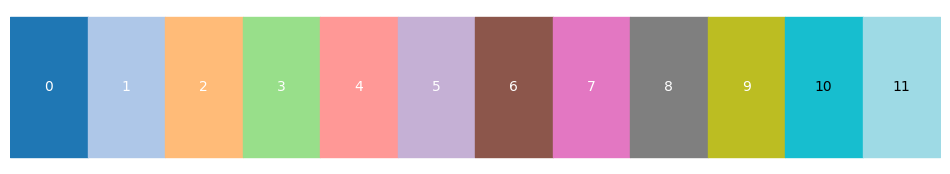

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a colormap with 12 distinct colors
cmap = plt.get_cmap("tab20")
colors = cmap(np.linspace(0, 1, 12))

# Plot each color as a square
plt.figure(figsize=(12, 2))
for i, color in enumerate(colors):
    plt.fill_between([i, i+1], 0, 1, color=color)
    plt.text(i + 0.5, 0.5, str(i), ha='center', va='center', color='white' if i < 10 else 'black')

plt.xlim(0, 12)
plt.axis('off')
plt.show()

In [83]:
# Single File Visualization Using Voxel Grids

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

from PIL import Image


# Load your semantic labeling data
data = np.load('model/sketch.nyu/results_sketch/1090.npy')

corresponding_rgb_image = Image.open("DATA/NYU-Original/RGB/NYU1090_colors.png")
corresponding_rgb_image.show()

voxel_size = 0.1

# Generate a colormap with 12 distinct colors
cmap = plt.get_cmap("tab20")
colors = cmap(np.linspace(0, 1, 12))

# Create a mapping from labels to colors
label_to_color = {label: colors[label][:3] for label in range(12)}


# Function to create a cube mesh at a given location with a given size and color
def create_colored_cube(center, size, color):
    size = size * 0.6   # The multiplicative factor controls space between the voxels 
    cube = o3d.geometry.TriangleMesh.create_box(width=size, height=size, depth=size)
    cube.translate(center - np.array([size / 2, size / 2, size / 2]))
    cube.paint_uniform_color(color)
    return cube


# Create a mesh for each voxel and combine them
meshes = []
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(data.shape[2]):
            label = data[i, j, k]
            if label in label_to_color:
                if label not in [0, 3, 10, 11]:
                    center = np.array([i, j, k]) * voxel_size
                    color = label_to_color[label]
                    cube = create_colored_cube(center, voxel_size, color)
                    meshes.append(cube)

# Combine all cube meshes into a single mesh
combined_mesh = o3d.geometry.TriangleMesh()
for mesh in meshes:
    combined_mesh += mesh

# Visualize the combined mesh
o3d.visualization.draw_geometries([combined_mesh])


In [78]:

# Single File Visualization Using Point Clouds

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

from PIL import Image


# Load your semantic labeling data
data = np.load('model/sketch.nyu/results_sketch/1090.npy')

corresponding_rgb_image = Image.open("DATA/NYU-Original/RGB/NYU1090_colors.png")
corresponding_rgb_image.show()


# Generate a colormap with 12 distinct colors
cmap = plt.get_cmap("tab20")
colors = cmap(np.linspace(0, 1, 12))

# Create a mapping from labels to colors
label_to_color = {label: colors[label][:3] for label in range(12)}

# Create a point cloud where each point represents a voxel's center, colored by its semantic label
points = []
colors = []

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        for k in range(data.shape[2]):
            label = data[i, j, k]
            if label in label_to_color:  # Check if the label has a defined color
                if label not in [0, 10]:
                    # Add the voxel center point (adjust the scaling as needed)
                    points.append([i, j, k])
                    # Add the color corresponding to the label
                    colors.append(label_to_color[label])

# Convert lists to NumPy arrays
points = np.array(points)
colors = np.array(colors)

# Create and visualize the colored point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([pcd])


In [23]:
import torch
print(torch.cuda.nccl.version())


(2, 19, 3)


### Visualize the Different Data from NYU Dataset

Keys in the .npz file: ['arr_1', 'arr_0']
Details for arr_1:
- Shape: (129600,)
- Data Type: float64
- First few elements: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Details for arr_0:
- Shape: (129600,)
- Data Type: float32
- First few elements: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Mean: -0.5687960982322693
Standard Deviation: 0.5206558108329773
Minimum: -1.0
Maximum: 1.0


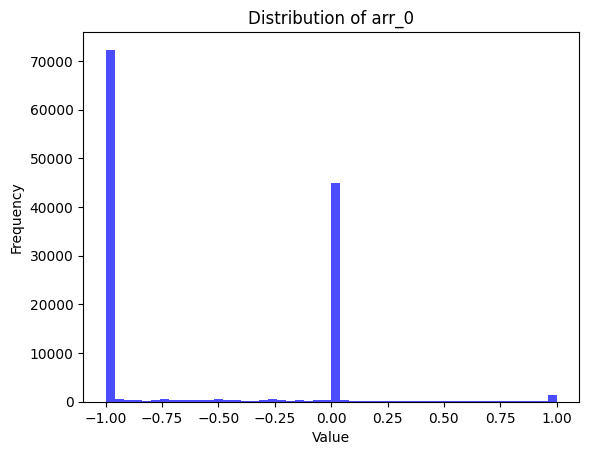

In [50]:
# Load and visualize the TSDF data

import numpy as np
import matplotlib.pyplot as plt

# data = np.load('DATA/scene-sense/sketch3D/sample_pc.npy')

file_path = 'DATA/NYU-Original/TSDF/0002.npz'
data = np.load(file_path)

# List all keys (array names) in the .npz file
keys = data.files
print("Keys in the .npz file:", keys)

# For each key, print the shape and other details of the corresponding array
for key in keys:
    array = data[key]
    print(f"Details for {key}:")
    print(f"- Shape: {array.shape}")
    print(f"- Data Type: {array.dtype}")
    print(f"- First few elements: {array.flatten()[:10]}")  # Show the first 10 elements as a sample

# Extract arr_0
arr_0 = data['arr_0']

# Calculate basic statistics
mean_arr_0 = np.mean(arr_0)
std_dev_arr_0 = np.std(arr_0)
min_arr_0 = np.min(arr_0)
max_arr_0 = np.max(arr_0)

# Print statistics
print(f"Mean: {mean_arr_0}")
print(f"Standard Deviation: {std_dev_arr_0}")
print(f"Minimum: {min_arr_0}")
print(f"Maximum: {max_arr_0}")

# Visualize the distribution with a histogram
plt.hist(arr_0, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of arr_0')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [31]:
# Generate MAPPING files that match the NYU dataset distribution but have the correct dimensions for our dataset.
# We have to do this or we get CUDA out of dimension assertion errors trying to index into tensors.
import numpy as np

# Array size and percentages
total_elements = 129600
majority_percentage = 0.97
minority_percentage = 1 - majority_percentage
majority_value = 65536
range_start = 0
range_end = 65500

# Calculate the number of elements for each group
majority_elements_count = int(total_elements * majority_percentage)
minority_elements_count = total_elements - majority_elements_count

# Create the majority of the array
array_majority = np.full(majority_elements_count, majority_value, dtype=np.int64)

# Generate the minority of the array
array_minority = np.random.randint(range_start, range_end + 1, size=minority_elements_count, dtype=np.int64)

# Combine the two arrays
final_array = np.concatenate((array_majority, array_minority))

# Ensure the array is shuffled so the minority values are not all at the end
np.random.shuffle(final_array)

# Check the shape and dtype (optional)
print(final_array.shape, final_array.dtype)


saved_results_path = 'DATA/scene-sense/Mapping/0002.npz'
# np.savez(saved_results_path, arr_0=final_array)

(129600,) int64


Keys in the .npz file: ['arr_0']
Details for arr_0:
- Shape: (129600,)
- Data Type: int64
- First few elements: [307200 307200 307200 307200 307200 307200 307200 307200 307200 307200]
Mean: 301409.17590277776
Standard Deviation: 32418.487136600514
Minimum: 21781
Maximum: 307200


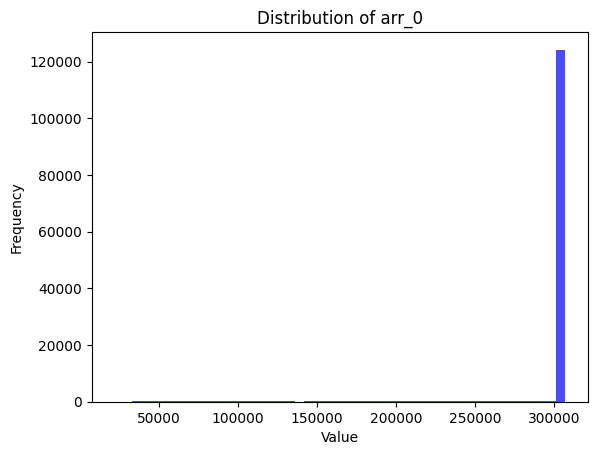

In [28]:
# Load and visualize the Mapping data

import numpy as np
import matplotlib.pyplot as plt

# data = np.load('DATA/scene-sense/sketch3D/sample_pc.npy') 

file_path = 'DATA/NYU-Original/Mapping/0006.npz'
# file_path = 'DATA/scene-sense/Mapping/mapping.npz'
data = np.load(file_path)

# List all keys (array names) in the .npz file
keys = data.files
print("Keys in the .npz file:", keys)

# For each key, print the shape and other details of the corresponding array
for key in keys:
    array = data[key]
    print(f"Details for {key}:")
    print(f"- Shape: {array.shape}")
    print(f"- Data Type: {array.dtype}")
    print(f"- First few elements: {array.flatten()[:10]}")  # Show the first 10 elements as a sample

# Extract arr_0
arr_0 = data['arr_0']

# Calculate basic statistics
mean_arr_0 = np.mean(arr_0)
std_dev_arr_0 = np.std(arr_0)
min_arr_0 = np.min(arr_0)
max_arr_0 = np.max(arr_0)

# Print statistics
print(f"Mean: {mean_arr_0}")
print(f"Standard Deviation: {std_dev_arr_0}")
print(f"Minimum: {min_arr_0}")
print(f"Maximum: {max_arr_0}")

# Visualize the distribution with a histogram
plt.hist(arr_0, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of arr_0')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


Data Shape: (65536, 3)


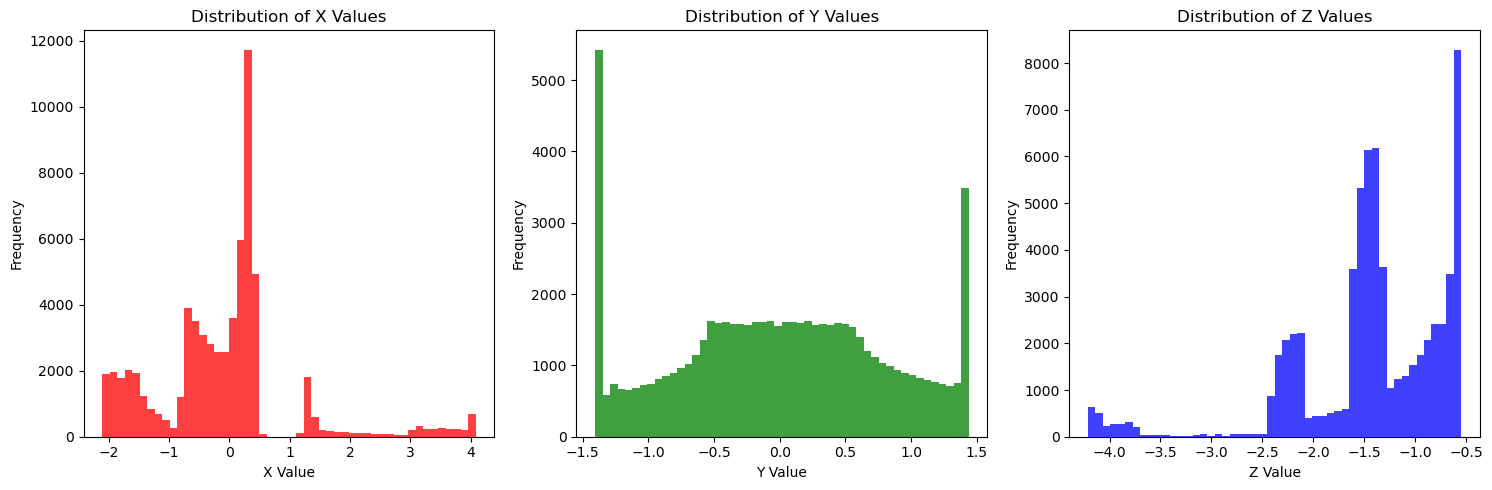

In [13]:
# Load and visualize the sketch3D data

import numpy as np
import matplotlib.pyplot as plt

# file_path = 'DATA/NYU/sketch3D/0006.npy'
file_path = 'DATA/scene-sense/sketch3D/sample_pc.npy'
data = np.load(file_path)

# Print the shape of the data
print(f"Data Shape: {data.shape}")

is_scene_sense = True

if not is_scene_sense:

    # Calculate and print basic statistics
    mean_data = np.mean(data)
    std_data = np.std(data)
    min_data = np.min(data)
    max_data = np.max(data)

    print(f"Mean: {mean_data}")
    print(f"Standard Deviation: {std_data}")
    print(f"Minimum Value: {min_data}")
    print(f"Maximum Value: {max_data}")

    # Assuming the data is 2D or you're interested in the entire distribution,
    # Flatten the data if it's 3D for the histogram
    if data.ndim > 2:
        data = data.flatten()

    # Visualize the distribution of data values with a histogram
    plt.hist(data, bins=50, alpha=0.75, color='blue')
    plt.title('Distribution of Data Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
else:
    # Separate the columns for clarity
    x_data = data[:, 0]
    y_data = data[:, 1]
    z_data = data[:, 2]

    # Plot histograms for each coordinate
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(x_data, bins=50, alpha=0.75, color='red')
    plt.title('Distribution of X Values')
    plt.xlabel('X Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.hist(y_data, bins=50, alpha=0.75, color='green')
    plt.title('Distribution of Y Values')
    plt.xlabel('Y Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(z_data, bins=50, alpha=0.75, color='blue')
    plt.title('Distribution of Z Values')
    plt.xlabel('Z Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


### Image Checker

In [32]:
# Image Checker

from PIL import Image

image = Image.open("DATA/scene-sense/RGB/house1.png")
print(image.size)
if image.mode == "RGB":
    print("This is an RGB image.")
elif image.mode == "RGBA":
    print("This image has 4 channels (could be RGBA or RGB-D if depth is encoded in the alpha channel).")
else:
    print("This image has an unusual mode: ", image.mode)


(256, 256)
This is an RGB image.


## HHA Conversion

In [28]:
# ALL OF THE FOLLOWING CODE IS FROM: https://github.com/charlesCXK/Depth2HHA-python/tree/master

# --*-- coding:utf-8 --*--
import numpy as np

import numpy as np
import cv2
from scipy import signal

'''
helper function
'''
def filterItChopOff(f, r, sp):
    f[np.isnan(f)] = 0
    H, W, d = f.shape
    B = np.ones([2 * r + 1, 2 * r + 1])     # 2r+1 * 2r+1 neighbourhood

    minSP = cv2.erode(sp, B, iterations=1)
    maxSP = cv2.dilate(sp, B, iterations=1)

    ind = np.where(np.logical_or(minSP != sp, maxSP != sp))

    spInd = np.reshape(range(np.size(sp)), sp.shape,'F')

    delta = np.zeros(f.shape)
    delta = np.reshape(delta, (H * W, d), 'F')
    f = np.reshape(f, (H * W, d),'F')

    # calculate delta

    I, J = np.unravel_index(ind, [H, W], 'C')
    for i in range(np.size(ind)):
        x = I[i]
        y = J[i]
        clipInd = spInd[max(0, x - r):min(H-1, x + r), max(0, y - r):min(W-1, y + r)]
        diffInd = clipInd[sp[clipInd] != sp[x, y]]
        delta[ind[i], :] = np.sum(f[diffInd, :], 1)
    delta = np.reshape(delta, (H, W, d), 'F')
    f = np.reshape(f, (H, W, d), 'F')
    fFilt = np.zeros([H, W, d])

    for i in range(f.shape[2]):
        #  fFilt(:,:,i) = filter2(B, f(:,:,i));
        tmp = cv2.filter2D(np.rot90(f[:, :, i], 2), -1, np.rot90(np.rot90(B, 2), 2))
        tmp = signal.convolve2d(np.rot90(f[:, :, i], 2), np.rot90(np.rot90(B, 2), 2), mode="same")
        fFilt[:, :, i] = np.rot90(tmp, 2)
    fFilt = fFilt - delta
    return fFilt

'''
helper function
'''
def mutiplyIt(AtA_1, Atb):
    result = np.zeros([Atb.shape[0], Atb.shape[1], 3])
    result[:, :, 0] = np.multiply(AtA_1[:, :, 0], Atb[:, :, 0]) + np.multiply(AtA_1[:, :, 1],
                                                                              Atb[:, :, 1]) + np.multiply(
        AtA_1[:, :, 2], Atb[:, :, 2])
    result[:, :, 1] = np.multiply(AtA_1[:, :, 1], Atb[:, :, 0]) + np.multiply(AtA_1[:, :, 3],
                                                                              Atb[:, :, 1]) + np.multiply(
        AtA_1[:, :, 4], Atb[:, :, 2])
    result[:, :, 2] = np.multiply(AtA_1[:, :, 2], Atb[:, :, 0]) + np.multiply(AtA_1[:, :, 4],
                                                                              Atb[:, :, 1]) + np.multiply(
        AtA_1[:, :, 5], Atb[:, :, 2])
    return result

'''
helper function
'''
def invertIt(AtA):
    AtA_1 = np.zeros([AtA.shape[0], AtA.shape[1], 6])
    AtA_1[:, :, 0] = np.multiply(AtA[:, :, 3], AtA[:, :, 5]) - np.multiply(AtA[:, :, 4], AtA[:, :, 4])
    AtA_1[:, :, 1] = -np.multiply(AtA[:, :, 1], AtA[:, :, 5]) + np.multiply(AtA[:, :, 2], AtA[:, :, 4])
    AtA_1[:, :, 2] = np.multiply(AtA[:, :, 1], AtA[:, :, 4]) - np.multiply(AtA[:, :, 2], AtA[:, :, 3])
    AtA_1[:, :, 3] = np.multiply(AtA[:, :, 0], AtA[:, :, 5]) - np.multiply(AtA[:, :, 2], AtA[:, :, 2])
    AtA_1[:, :, 4] = -np.multiply(AtA[:, :, 0], AtA[:, :, 4]) + np.multiply(AtA[:, :, 1], AtA[:, :, 2])
    AtA_1[:, :, 5] = np.multiply(AtA[:, :, 0], AtA[:, :, 3]) - np.multiply(AtA[:, :, 1], AtA[:, :, 1])

    x1 = np.multiply(AtA[:, :, 0], AtA_1[:, :, 0])
    x2 = np.multiply(AtA[:, :, 1], AtA_1[:, :, 1])
    x3 = np.multiply(AtA[:, :, 2], AtA_1[:, :, 2])

    detAta = x1 + x2 + x3
    return AtA_1, detAta

'''
Compute the direction of gravity
N: normal field
iter: number of 'big' iterations
'''
def getYDir(N, angleThresh, iter, y0):
    y = y0
    for i in range(len(angleThresh)):
        thresh = np.pi * angleThresh[i] / 180   # convert it to radian measure
        y = getYDirHelper(N, y, thresh, iter[i])
    return y

'''
N: HxWx3 matrix with normal at each pixel.
y0: the initial gravity direction
thresh: in degrees the threshold for mapping to parallel to gravity and perpendicular to gravity
iter: number of iterations to perform
'''
def getYDirHelper(N, y0, thresh, num_iter):
    dim = N.shape[0] * N.shape[1]

    # change the third dimension to the first-order. (480, 680, 3) => (3, 480, 680)
    nn = np.swapaxes(np.swapaxes(N,0,2),1,2)
    nn = np.reshape(nn, (3, dim), 'F')

    # remove these whose number is NAN
    idx = np.where(np.invert(np.isnan(nn[0,:])))[0]
    nn = nn[:,idx]

    # Set it up as a optimization problem
    yDir = y0;
    for i in range(num_iter):
        sim0 = np.dot(yDir.T, nn)
        indF = abs(sim0) > np.cos(thresh)       # calculate 'floor' set.    |sin(theta)| < sin(thresh) ==> |cos(theta)| > cos(thresh)
        indW = abs(sim0) < np.sin(thresh)       # calculate 'wall' set.
        if(len(indF.shape) == 2):
            NF = nn[:, indF[0,:]]
            NW = nn[:, indW[0,:]]
        else:
            NF = nn[:, indF]
            NW = nn[:, indW]
        A = np.dot(NW, NW.T) - np.dot(NF, NF.T)
        b = np.zeros([3,1])
        c = NF.shape[1]
        w,v = np.linalg.eig(A)      # w:eigenvalues; v:eigenvectors
        min_ind = np.argmin(w)      # min index
        newYDir = v[:,min_ind]
        yDir = newYDir * np.sign(np.dot(yDir.T, newYDir))
    return yDir

'''
getRMatrix: Generate a rotation matrix that
            if yf is a scalar, rotates about axis yi by yf degrees
            if yf is an axis, rotates yi to yf in the direction given by yi x yf
Input: yi is an axis 3x1 vector
       yf could be a scalar of axis

'''
def getRMatrix(yi, yf):
    if (np.isscalar(yf)):
        ax = yi / np.linalg.norm(yi)        # norm(A) = max(svd(A))
        phi = yf
    else:
        yi = yi / np.linalg.norm(yi)
        yf = yf / np.linalg.norm(yf)
        ax = np.cross(yi.T, yf.T).T
        ax = ax / np.linalg.norm(ax)
        # find angle of rotation
        phi = np.degrees(np.arccos(np.dot(yi.T, yf)))

    if (abs(phi) > 0.1):
        phi = phi * (np.pi / 180)
        ax = ax.flatten()

        s_hat = np.array([[0, -ax[2], ax[1]],
                          [ax[2], 0, -ax[0]],
                          [-ax[1], ax[0], 0]])
        R = np.eye(3) + np.sin(phi) * s_hat + (1 - np.cos(phi)) * np.dot(s_hat, s_hat)      # dot???
    else:
        R = np.eye(3)
    return R

'''
Calibration of gravity direction 
'''
def rotatePC(pc, R):
    if(np.array_equal(R, np.eye(3))):
        return pc
    else:
        R = R.astype(np.float64)
        dim = pc.shape[0] * pc.shape[1]
        pc = np.swapaxes(np.swapaxes(pc, 0, 2), 1, 2)
        res = np.reshape(pc, (3, dim), 'F')
        res = np.dot(R, res)
        res = np.reshape(res, pc.shape, 'F')
        res = np.swapaxes(np.swapaxes(res, 0, 1), 1, 2)
        return res

np.seterr(divide='ignore', invalid='ignore')

'''
z: depth image in 'centimetres'
missingMask: a mask
C: camera matrix
'''
def processDepthImage(z, missingMask, C):
    yDirParam_angleThresh = np.array([45, 15]) # threshold to estimate the direction of the gravity
    yDirParam_iter = np.array([5, 5])
    yDirParam_y0 = np.array([0, 1, 0])

    normalParam_patchSize = np.array([3, 10])

    X, Y, Z = getPointCloudFromZ(z, C, 1)

    # with open('pd.txt', 'w', encoding='utf-8') as f:
    #     for i in range(X.shape[0]):
    #         for j in range(X.shape[1]):
    #             f.write('{} {} {}\n'.format(str(X[i,j]), str(Y[i,j]), str(Z[i,j])))

    # restore x-y-z position
    pc = np.zeros([z.shape[0], z.shape[1], 3])
    pc[:,:,0] = X
    pc[:,:,1] = Y
    pc[:,:,2] = Z

    N1, b1 = computeNormalsSquareSupport(z/100, missingMask, normalParam_patchSize[0],
    1, C, np.ones(z.shape))
    N2, b2 = computeNormalsSquareSupport(z/100, missingMask, normalParam_patchSize[1],
    1, C, np.ones(z.shape))

    N = N1

    # Compute the direction of gravity
    yDir = getYDir(N2, yDirParam_angleThresh, yDirParam_iter, yDirParam_y0)
    y0 = np.array([[0, 1, 0]]).T
    R = getRMatrix(y0, yDir)

    # rotate the pc and N
    NRot = rotatePC(N, R.T)

    pcRot = rotatePC(pc, R.T)
    h = -pcRot[:,:,1]
    yMin = np.percentile(h, 0)
    if (yMin > -90):
        yMin = -130
    h = h - yMin

    return pc, N, yDir, h,  pcRot, NRot

'''
getPointCloudFromZ: use depth image and camera matrix to get pointcloud
Z is in 'centimetres'
C: camera matrix
s: is the factor by which Z has been upsampled
'''
def getPointCloudFromZ(Z, C, s=1):
    Z = Z.mean(axis=2)
    h, w = Z.shape
    xx, yy = np.meshgrid(np.array(range(w))+1, np.array(range(h))+1)
    # color camera parameters
    cc_rgb = C[0:2,2] * s       # the first two lines of colomn-3, x0 and the y0
    fc_rgb = np.diag(C[0:2,0:2]) * s    # number on the diagonal line
    x3 = np.multiply((xx - cc_rgb[0]), Z) / fc_rgb[0]
    y3 = np.multiply((yy - cc_rgb[1]), Z) / fc_rgb[1]
    z3 = Z
    return x3, y3, z3

'''
  Clip out a 2R+1 x 2R+1 window at each point and estimate 
  the normal from points within this window. In case the window 
  straddles more than a single superpixel, only take points in the 
  same superpixel as the centre pixel. 
  
Input:
    depthImage: in meters
    missingMask:  boolean mask of what data was missing
    R: radius of clipping
    sc: to upsample or not
    superpixels:  superpixel map to define bounadaries that should
                    not be straddled
'''
def computeNormalsSquareSupport(depthImage, missingMask, R, sc, cameraMatrix, superpixels):
    depthImage = depthImage*100     # convert to centi metres
    X, Y, Z = getPointCloudFromZ(depthImage, cameraMatrix, sc)
    Xf = X
    Yf = Y
    Zf = Z
    pc = np.zeros([depthImage.shape[0], depthImage.shape[1], 3])
    pc[:,:,0] = Xf
    pc[:,:,1] = Yf
    pc[:,:,2] = Zf
    XYZf = np.copy(pc)

    # find missing value
    # ind = np.where(missingMask == 1)
    # X[ind] = np.nan
    # Y[ind] = np.nan
    # Z[ind] = np.nan

    one_Z = np.expand_dims(1 / Z, axis=2)
    X_Z = np.divide(X, Z)
    Y_Z = np.divide(Y, Z)
    one = np.copy(Z)
    one[np.invert(np.isnan(one[:, :]))] = 1
    ZZ = np.multiply(Z, Z)
    X_ZZ = np.expand_dims(np.divide(X, ZZ), axis=2)
    Y_ZZ = np.expand_dims(np.divide(Y, ZZ), axis=2)

    X_Z_2 = np.expand_dims(np.multiply(X_Z, X_Z), axis=2)
    XY_Z = np.expand_dims(np.multiply(X_Z, Y_Z), axis=2)
    Y_Z_2 = np.expand_dims(np.multiply(Y_Z, Y_Z), axis=2)

    AtARaw = np.concatenate((X_Z_2, XY_Z, np.expand_dims(X_Z, axis=2), Y_Z_2,
                             np.expand_dims(Y_Z, axis=2), np.expand_dims(one, axis=2)), axis=2)

    AtbRaw = np.concatenate((X_ZZ, Y_ZZ, one_Z), axis=2)

    # with clipping
    AtA = filterItChopOff(np.concatenate((AtARaw, AtbRaw), axis=2), R, superpixels)
    Atb = AtA[:, :, AtARaw.shape[2]:]
    AtA = AtA[:, :, :AtARaw.shape[2]]

    AtA_1, detAtA = invertIt(AtA)
    N = mutiplyIt(AtA_1, Atb)

    divide_fac = np.sqrt(np.sum(np.multiply(N, N), axis=2))
    # with np.errstate(divide='ignore'):
    b = np.divide(-detAtA, divide_fac)
    for i in range(3):
        N[:, :, i] = np.divide(N[:, :, i], divide_fac)

    # Reorient the normals to point out from the scene.
    # with np.errstate(invalid='ignore'):
    SN = np.sign(N[:, :, 2])
    SN[SN == 0] = 1
    extend_SN = np.expand_dims(SN, axis=2)
    extend_SN = np.concatenate((extend_SN, extend_SN, extend_SN), axis=2)
    N = np.multiply(N, extend_SN)
    b = np.multiply(b, SN)
    sn = np.sign(np.sum(np.multiply(N, XYZf), axis=2))
    sn[np.isnan(sn)] = 1
    sn[sn == 0] = 1
    extend_sn = np.expand_dims(sn, axis=2)
    N = np.multiply(extend_sn, N)
    b = np.multiply(b, sn)
    return N, b

'''
getCameraParam: get the camera matrix
colOrZ: color or depth
'''
def getCameraParam(colorOrZ='color'):
    # Pulled this camera matrix from: https://github.com/OSU-AIMS/tic-tac-toe/issues/12
    hfov = float(90) * np.pi / 180.
    C = np.array([
        [1 / np.tan(hfov / 2.), 0., 0., 0.],
        [0., 1 / np.tan(hfov / 2.), 0., 0.],
        [0., 0.,  1, 0],
        [0., 0., 0, 1]])
    
    # if colorOrZ == 'color':
    #     fx_rgb = 5.1885790117450188e+02
    #     fy_rgb = 5.1946961112127485e+02
    #     cx_rgb = 3.2558244941119034e+02
    #     cy_rgb = 2.5373616633400465e+02
    #     C = np.array([[fx_rgb, 0, cx_rgb], [0, fy_rgb, cy_rgb], [0, 0, 1]])
    # else:
    #     fx_d = 5.8262448167737955e+02
    #     fy_d = 5.8269103270988637e+02
    #     cx_d = 3.1304475870804731e+02
    #     cy_d = 2.3844389626620386e+02
    #     C = np.array([[fx_d, 0, cx_d], [0, fy_d, cy_d], [0, 0, 1]])
    return C

In [29]:
# Conversion to HHA
# --*-- coding:utf-8 --*--
import math
import cv2
import os
import math
import numpy as np


'''
must use 'COLOR_BGR2GRAY' here, or you will get a different gray-value with what MATLAB gets.
'''
def getImage(root='/home/lorin/Documents/TorchSSC/DATA/scene-sense/RGB/'):
    # D = np.load(os.path.join(root, 'sample_pc.npy'))
    # RD = np.zeros_like(D)

    # Normalized
    # D = cv2.imread(os.path.join(root, 'house2.png'), cv2.COLOR_BGR2GRAY) / 255
    # RD = cv2.imread(os.path.join(root, 'house2.png'), cv2.COLOR_BGR2GRAY) / 255

    D = cv2.imread(os.path.join(root, 'house2.png'), cv2.COLOR_BGR2GRAY)
    RD = cv2.imread(os.path.join(root, 'house2.png'), cv2.COLOR_BGR2GRAY)
    return D, RD

'''
C: Camera matrix
D: Depth image, the unit of each element in it is "meter"
RD: Raw depth image, the unit of each element in it is "meter"
'''
def getHHA(C, D, RD):
    missingMask = (RD == 0)
    pc, N, yDir, h, pcRot, NRot = processDepthImage(D * 100, missingMask, C)

    tmp = np.multiply(N, yDir)
    acosValue = np.minimum(1,np.maximum(-1,np.sum(tmp, axis=2)))
    angle = np.array([math.degrees(math.acos(x)) for x in acosValue.flatten()])
    angle = np.reshape(angle, h.shape)

    '''
    Must convert nan to 180 as the MATLAB program actually does. 
    Or we will get a HHA image whose border region is different
    with that of MATLAB program's output.
    '''
    angle[np.isnan(angle)] = 180        


    pc[:,:,2] = np.maximum(pc[:,:,2], 100)
    I = np.zeros(pc.shape)

    # opencv-python save the picture in BGR order.
    I[:,:,2] = 31000/pc[:,:,2]
    I[:,:,1] = h
    I[:,:,0] = (angle + 128-90)

    # print(np.isnan(angle))

    '''
    np.uint8 seems to use 'floor', but in matlab, it seems to use 'round'.
    So I convert it to integer myself.
    '''
    I = np.rint(I)

    # np.uint8: 256->1, but in MATLAB, uint8: 256->255
    I[I>255] = 255
    HHA = I.astype(np.uint8)
    return HHA

if __name__ == "__main__":
    D, RD = getImage()
    camera_matrix = getCameraParam('color')
    print('max gray value: ', np.max(D))        # make sure that the image is in 'meter'
    hha = getHHA(camera_matrix, D, RD)
    hha_complete = getHHA(camera_matrix, D, D)
    cv2.imwrite('hha_2.png', hha)
    # cv2.imwrite('hha_complete_2.png', hha_complete)
    # cv2.imshow("HHA image", hha)

max gray value:  255


## TSDF Conversion

In [50]:
# Camera intrinsics
hfov = 90
W = 256
H = 256

hfov_rad = float(hfov) * np.pi / 180.
CAMERA_INTRINSICS = np.array([
    [1 / np.tan(hfov_rad / 2.), 0., W / 2.],
    [0., 1 / np.tan(hfov_rad / 2.), H / 2.],
    [0., 0.,  1]])

In [49]:
### Numpy Point Cloud to Depth Image Conversion (METHOD ONE)
import numpy as np
import matplotlib.pyplot as plt

def pc_to_depth(point_cloud, hfov=90, W=256, H=256):
    # Camera intrinsics
    hfov_rad = float(hfov) * np.pi / 180.
    K = np.array([
        [1 / np.tan(hfov_rad / 2.), 0., W / 2.],
        [0., 1 / np.tan(hfov_rad / 2.), H / 2.],
        [0., 0.,  1]])
    
    # Assuming point cloud is N x 3
    N = point_cloud.shape[0]
    
    # Convert point cloud (X, Y, Z) back to camera space points (X, Y, Z)
    xyz_c = np.hstack((point_cloud, np.ones((N, 1))))  # This line is correct
    
    # Ensure xyz_c is correctly shaped before projection
    # The issue is with using the entire xyz_c including the appended ones directly with K which is 3x3
    # You need to use only the X, Y, Z components for dot product with K
    xyz_c = xyz_c[:, :3]  # This line adjusts the xyz_c to be compatible with the K matrix's expectation
    
    # Project points back onto image plane
    xy_c = np.dot(K, xyz_c.T)  # This should now work without error
    xy_c /= xy_c[2, :]  # Normalize by Z to get (x, y, 1)

    xy_c = np.nan
    
    # Initialize depth image with zeros (or a very large value to indicate no measurement)
    depth_image = np.zeros((H, W))
    
    # Map points to pixels and update depth values
    for i in range(xy_c.shape[1]):
        x, y = int(xy_c[0, i]), int(xy_c[1, i])
        if 0 <= x < W and 0 <= y < H:
            # Update depth image with the Z value (negate to convert back)
            depth_image[y, x] = -xyz_c[i, 2]
    
    return depth_image

file_path = 'DATA/scene-sense/sketch3D/sample_pc1.npy'
data = np.load(file_path)
depth_image = pc_to_depth(data)
#print(depth_image)

saved_results_path = 'DATA/scene-sense/depth_from_pc/depth_image1.npy'
np.save(saved_results_path, depth_image)

# Calculate and print basic statistics
mean_data = np.mean(depth_image)
std_data = np.std(depth_image)
min_data = np.min(depth_image)
max_data = np.max(depth_image)

print(depth_image.shape)
print(mean_data)
print(min_data, max_data)

(256, 256)
0.0001593304232301307
0.0 2.3852858543395996


In [79]:
import numpy as np

# # Don't think this is needed for anything tbh
# def depth_to_3d(depth_image, intrinsics):
#     """
#     Convert a depth image to a set of 3D points.
#     `depth_image`: 2D numpy array with depth values.
#     `intrinsics`: Camera intrinsic matrix as a numpy array.
#     """
#     points = []
#     h, w = depth_image.shape
#     for i in range(h):
#         for j in range(w):
#             # Convert pixel coordinates to camera coordinates
#             z = depth_image[i, j]
#             x = (j - intrinsics[0, 2]) * z / intrinsics[0, 0]
#             y = (i - intrinsics[1, 2]) * z / intrinsics[1, 1]
#             points.append([x, y, z])
#     return np.array(points)

def compute_tsdf(points, voxel_grid_origin, voxel_size, grid_shape, truncation_dist):
    """
    Compute the TSDF for a set of 3D points.
    `points`: 3D points as a numpy array.
    `voxel_grid_origin`: Origin of the voxel grid (x, y, z).
    `voxel_size`: Size of each voxel.
    `grid_shape`: Shape of the grid (nx, ny, nz).
    `truncation_dist`: Maximum distance to store in TSDF.
    """
    tsdf = np.full(grid_shape, truncation_dist, dtype=np.float32)
    for point in points:
        voxel_coord = np.floor((point - voxel_grid_origin) / voxel_size).astype(int)
        for i in range(max(0, voxel_coord[0]-1), min(grid_shape[0], voxel_coord[0]+2)):
            for j in range(max(0, voxel_coord[1]-1), min(grid_shape[1], voxel_coord[1]+2)):
                for k in range(max(0, voxel_coord[2]-1), min(grid_shape[2], voxel_coord[2]+2)):
                    voxel_center = voxel_grid_origin + voxel_size * np.array([i+0.5, j+0.5, k+0.5])
                    dist = np.linalg.norm(voxel_center - point) - voxel_size / 2
                    if abs(dist) < abs(tsdf[i, j, k]):
                        # tsdf[i, j, k] = dist if dist <= truncation_dist else tsdf[i, j, k]
                        tsdf[i, j, k] = dist
    tsdf = np.clip(tsdf, -truncation_dist, truncation_dist)
    return tsdf

# Example parameters (you'll need to adjust these)
point_cloud = np.load('DATA/scene-sense/sketch3D/sample_pc.npy')
voxel_grid_origin = np.array([-1, -1, 0])  # Origin of the voxel grid
voxel_size = 0.0001
grid_shape = np.array([60, 36, 60])
truncation_dist = 1.0

tsdf = compute_tsdf(point_cloud, voxel_grid_origin, voxel_size, grid_shape, truncation_dist)
print(tsdf.shape)
print(np.min(tsdf), np.max(tsdf))
print(np.mean(tsdf))
print(np.std(tsdf))

# saved_results_path = 

(60, 36, 60)
1.0 1.0
1.0
0.0


In [74]:
import numpy as np
from scipy.spatial import cKDTree

point_cloud = np.load('DATA/scene-sense/sketch3D/sample_pc1.npy')
xRange = (-1.0, 1.0)
yRange = (-1.0, 1.0)
zRange = (-1.0, 1.0)
voxelSize = 0.01
voxelMargin = 1.0

def pointCloud2TDF(points, xRange, yRange, zRange, voxelSize, voxelMargin):
    """
    Given a point cloud, compute a voxel grid of TDF values.

    Parameters:
    - points: (N, 3) ndarray of point cloud coordinates.
    - xRange, yRange, zRange: tuples of (min, max) specifying the bounding box.
    - voxelSize: float, size of each voxel.
    - voxelMargin: float, margin for truncation.

    Returns:
    - voxelGridTDF: 3D ndarray of truncated distance function values.
    """
    
    # Compute voxel grid centers
    gridX, gridY, gridZ = np.meshgrid(
        np.arange(xRange[0] + voxelSize / 2, xRange[1], voxelSize),
        np.arange(yRange[0] + voxelSize / 2, yRange[1], voxelSize),
        np.arange(zRange[0] + voxelSize / 2, zRange[1], voxelSize),
        indexing='ij'
    )

    # Flatten the grid for KD-tree querying
    gridPoints = np.vstack((gridX.ravel(), gridY.ravel(), gridZ.ravel())).T

    # Build KD-tree and do 1-NN search
    tree = cKDTree(points)
    nnDist, _ = tree.query(gridPoints, k=1)

    # Reshape values into voxel grid
    voxelGridShape = gridX.shape
    voxelGridTDF = nnDist.reshape(voxelGridShape)

    # Apply truncation
    voxelGridTDF = 1.0 - np.minimum(voxelGridTDF / (voxelSize * voxelMargin), 1.0)

    return voxelGridTDF

tdf = pointCloud2TDF(point_cloud, xRange, yRange, zRange, voxelSize, voxelMargin)
print(tdf.shape)
print(np.min(tdf), np.max(tdf))
print(np.mean(tdf))
print(np.std(tdf))


(200, 200, 200)
0.0 0.993385515364244
0.0006594718924177311
0.01822670871936211


In [75]:
saved_results_path = 'DATA/scene-sense/TSDF/tdf1.npz'
np.savez(saved_results_path, arr_0=tdf)